In [1]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d chrisfilo/urbansound8k

100% 5.61G/5.61G [00:46<00:00, 191MB/s]
100% 5.61G/5.61G [00:46<00:00, 129MB/s]


In [5]:
!unzip urbansound8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: fold4/151877-5-1-0.wav  
  inflating: fold4/154758-5-0-0.wav  
  inflating: fold4/154758-5-0-1.wav  
  inflating: fold4/154758-5-0-10.wav  
  inflating: fold4/154758-5-0-11.wav  
  inflating: fold4/154758-5-0-12.wav  
  inflating: fold4/154758-5-0-13.wav  
  inflating: fold4/154758-5-0-14.wav  
  inflating: fold4/154758-5-0-15.wav  
  inflating: fold4/154758-5-0-16.wav  
  inflating: fold4/154758-5-0-17.wav  
  inflating: fold4/154758-5-0-18.wav  
  inflating: fold4/154758-5-0-19.wav  
  inflating: fold4/154758-5-0-2.wav  
  inflating: fold4/154758-5-0-20.wav  
  inflating: fold4/154758-5-0-21.wav  
  inflating: fold4/154758-5-0-3.wav  
  inflating: fold4/154758-5-0-4.wav  
  inflating: fold4/154758-5-0-5.wav  
  inflating: fold4/154758-5-0-6.wav  
  inflating: fold4/154758-5-0-7.wav  
  inflating: fold4/154758-5-0-8.wav  
  inflating: fold4/154758-5-0-9.wav  
  inflating: fold4/155320-3-0-0.wav  
  inflating: fold4/156362

In [6]:
file = 'UrbanSound8K.csv'

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv(file)
df

slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          dog_bark  
1           2  children_playing  
2           2  children_playing  
3           2  children_playing  
4           2  children_playing  
...       ...               ...  
8727        1          car_horn  
8728        1          car_horn  
8729        1          car_horn  
8730        1          car_horn  
8731        1          car_horn  

[8732 rows x 8 columns]

In [9]:
#Mapping Classes
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
pd.DataFrame(sorted(list(class_map.items())))

0                 1
0  0   air_conditioner
1  1          car_horn
2  2  children_playing
3  3          dog_bark
4  4          drilling
5  5     engine_idling
6  6          gun_shot
7  7        jackhammer
8  8             siren
9  9      street_music

Extracting features using Librosa

In [12]:
class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [23]:
wavfilehelper = WavFileHelper()
filepath = ''
audiodata = []
for index, row in df.iterrows():
    
    file_name = os.path.join(os.path.abspath(filepath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [24]:
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [25]:
features = []

# Iterate through each sound file and extract the features 
for index, row in df.iterrows():
    
    file_name = os.path.join(os.path.abspath(filepath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["classID"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [30]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
y = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

In [31]:
x_train1 = x_train 
x_test1 = x_test
y_train1 = y_train
y_test1 = y_test

In [32]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
print(x_train.shape)

num_labels = y.shape[1]
filter_size = 3

(6985, 40, 174, 1)


In [33]:
#Model Creation
model_relu = Sequential()
model_relu.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))
model_relu.add(GlobalAveragePooling2D())
model_relu.add(Flatten())
model_relu.add(Dense(num_labels, activation='softmax'))

In [34]:
model_relu.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [36]:
model_relu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

In [37]:
num_epochs = 100
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
history_relu = model_relu.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), callbacks=[checkpointer], verbose=1)

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 3.1758 - accuracy: 0.2050
Epoch 1: val_loss improved from inf to 2.08566, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 34s 1s/step - loss: 3.1758 - accuracy: 0.2050 - val_loss: 2.0857 - val_accuracy: 0.2244
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 1.7697 - accuracy: 0.3735
Epoch 2: val_loss improved from 2.08566 to 1.79499, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 34s 1s/step - loss: 1.7697 - accuracy: 0.3735 - val_loss: 1.7950 - val_accuracy: 0.3612
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 1.5144 - accuracy: 0.4681
Epoch 3: val_loss improved from 1.79499 to 1.64026, saving model to saved_models/weights.best.basic_cnn.hdf5
28/28 [==============================] - 34s 1s/step - loss: 1.5144 - accuracy: 0.4681 - val_loss: 1.6403 - val_accuracy: 0.4516
Epoch

In [38]:
import IPython.display as ipd
def predict(path, model):
    audio = np.array([extract_features(path)])
    classid = np.argmax(model.predict(audio)[0])
    classes = df.groupby('classID')['class'].unique()
    classes
    print('Class predicted :',classes[classid][0],'\n\n')
    return ipd.Audio(path)

In [39]:
score = model_relu.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model_relu.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9739441871643066
Testing Accuracy:  0.9158557653427124


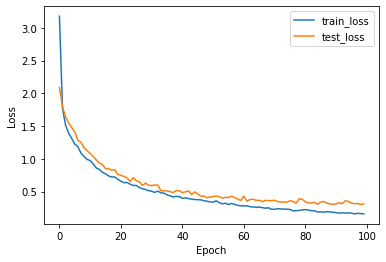

In [40]:
# Plotting Loss of CNN 2D - ReLu Model

metrics = history_relu.history
plt.plot(history_relu.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

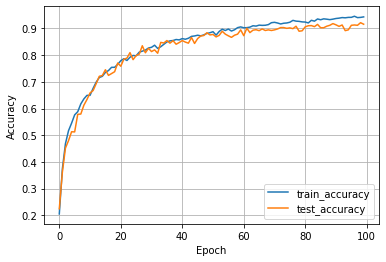

In [41]:
# Plotting Accuracy of CNN 2D - ReLu Model

plt.plot(history_relu.history['accuracy'], label='train_accuracy')
plt.plot(history_relu.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [42]:
#Predicting few samples
predict('fold4/107653-9-0-14.wav', model_relu)

1/1 [==============================] - 0s 154ms/step
Class predicted : street_music 




In [43]:
predict('fold10/101382-2-0-42.wav', model_relu)

1/1 [==============================] - 0s 33ms/step
Class predicted : children_playing 




In [44]:
predict('fold1/103074-7-1-4.wav', model_relu)

1/1 [==============================] - 0s 27ms/step
Class predicted : jackhammer 




In [45]:
predict('fold10/189985-0-0-0.wav', model_relu)

1/1 [==============================] - 0s 27ms/step
Class predicted : air_conditioner 




In [47]:
#Classification Report
from sklearn.metrics import confusion_matrix, classification_report
ytrue = np.argmax(y_test, axis=1)
ypred = np.argmax(model_relu.predict(x_test), axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue, ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue, ypred))

55/55 [==============================] - 2s 43ms/step

Confusion Matrix :


[[208   0   1   1   1   2   0   0   2   3]
 [  0  85   0   1   3   0   0   0   0   1]
 [  5   0 171   4   5   4   0   1   4   5]
 [  1   6   7 171   2   4   2   0   3   3]
 [  3   0   2   0 188   0   1   5   0   1]
 [  0   2   0   0   4 195   1   1   0   0]
 [  0   0   0   0   0   0  64   0   1   0]
 [  1   0   0   0   8   0   0 176   0   0]
 [  2   0   0   3   3   2   0   0 187   0]
 [  6   2  11   1   4   6   0   4   2 155]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.92      0.95      0.94       218
           1       0.89      0.94      0.92        90
           2       0.89      0.86      0.87       199
           3       0.94      0.86      0.90       199
           4       0.86      0.94      0.90       200
           5       0.92      0.96      0.94       203
           6       0.94      0.98      0.96        65
           7       0.94      0.